In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
TRAIN_IMG_PATH ="/content/drive/MyDrive/Med practice 2 data/training_set-20260122T090755Z-1-001/training_set/training_set"
TEST_IMG_PATH  ="/content/drive/MyDrive/Med practice 2 data/test_set-20260122T090756Z-1-001/test_set/test_set"

TRAIN_CSV = "/content/drive/MyDrive/Med practice 2 data/training_set_pixel_size_and_HC.csv"
TEST_CSV  ="/content/drive/MyDrive/Med practice 2 data/test_set_pixel_size.csv"


In [4]:
import cv2
import os
import matplotlib.pyplot as plt

img_name = os.listdir(TRAIN_IMG_PATH)[0]
img_path = os.path.join(TRAIN_IMG_PATH, img_name)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)



Image: (540, 800) uint8
Annotation: (540, 800) uint8


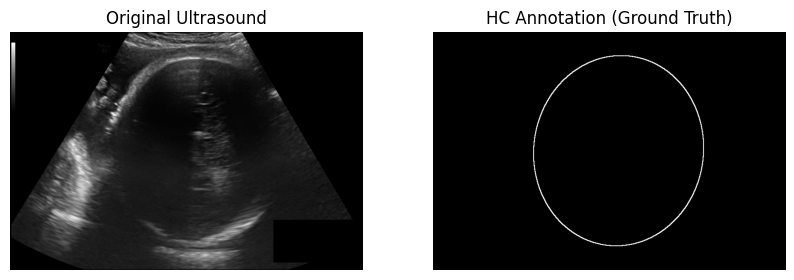

In [5]:
import cv2
import matplotlib.pyplot as plt
import os

IMG_PATH = os.path.join(TRAIN_IMG_PATH, "805_HC.png")
ANN_PATH = os.path.join(TRAIN_IMG_PATH, "805_HC_Annotation.png")

img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
ann = cv2.imread(ANN_PATH, cv2.IMREAD_GRAYSCALE)

print("Image:", img.shape, img.dtype)
print("Annotation:", ann.shape, ann.dtype)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original Ultrasound")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ann, cmap="gray")
plt.title("HC Annotation (Ground Truth)")
plt.axis("off")

plt.show()


In [23]:
df = pd.read_csv("training_set_pixel_size_and_HC.csv")
df.columns = df.columns.str.strip()

print(df.head())
print("Total rows:", len(df))


     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81
Total rows: 999


In [24]:
IMG_SIZE = 256

def preprocess_sample(row, img_size=256):
    # paths
    img_path = os.path.join(TRAIN_IMG_PATH, row["filename"])
    ann_path = img_path.replace(".png", "_Annotation.png")

    # load
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    ann = cv2.imread(ann_path, cv2.IMREAD_GRAYSCALE)

    # resize
    img = cv2.resize(img, (img_size, img_size))
    ann = cv2.resize(ann, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    # normalize image only
    img = img.astype("float32") / 255.0

    # binary mask
    ann = (ann > 0).astype("float32")

    # add channel dimension
    img = img[..., None]   # (H, W, 1)
    ann = ann[..., None]   # (H, W, 1)

    # numeric labels from CSV
    pixel_size = row["pixel size(mm)"]
    hc_value = row["head circumference (mm)"]

    return img, ann, pixel_size, hc_value


In [25]:
print(df.columns.tolist())


['filename', 'pixel size(mm)', 'head circumference (mm)']


In [26]:
row = df.iloc[0]
img, ann, px, hc = preprocess_sample(row)

print("Image:", img.shape, img.dtype)
print("Mask:", ann.shape, ann.dtype)
print("Pixel size:", px)
print("HC (mm):", hc)


Image: (256, 256, 1) float32
Mask: (256, 256, 1) float32
Pixel size: 0.0691358041432
HC (mm): 44.3


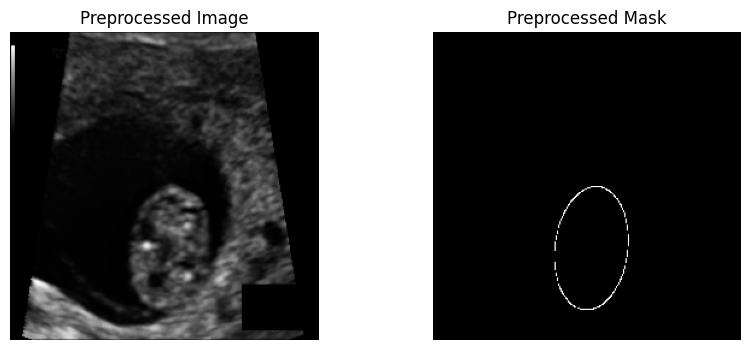

In [17]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img.squeeze(), cmap="gray")
plt.title("Preprocessed Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ann.squeeze(), cmap="gray")
plt.title("Preprocessed Mask")
plt.axis("off")

plt.show()


In [27]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 699
Val: 150
Test: 150


In [28]:
row = train_df.iloc[0]

img, ann, px, hc = preprocess_sample(row)

print("Image:", img.shape, img.dtype)
print("Mask:", ann.shape, ann.dtype)
print("Pixel size:", px)
print("HC (mm):", hc)


Image: (256, 256, 1) float32
Mask: (256, 256, 1) float32
Pixel size: 0.156303271651
HC (mm): 175.84


In [29]:
def data_generator(df, batch_size=8, shuffle=True):
    while True:
        if shuffle:
            df = df.sample(frac=1).reset_index(drop=True)

        for i in range(0, len(df), batch_size):
            batch = df.iloc[i:i + batch_size]

            images = []
            pixel_sizes = []
            labels = []

            for _, row in batch.iterrows():
                img, ann, px, hc = preprocess_sample(row)

                images.append(img)
                pixel_sizes.append(px)
                labels.append(hc)

            yield (
                {
                    "image_input": np.array(images),
                    "pixel_input": np.array(pixel_sizes)
                },
                np.array(labels)
            )


In [30]:
image_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="image_input")

x = layers.Conv2D(32, 3, padding="same", activation="relu")(image_input)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)

pixel_input = layers.Input(shape=(1,), name="pixel_input")
p = layers.Dense(16, activation="relu")(pixel_input)
p = layers.Dense(16, activation="relu")(p)

combined = layers.concatenate([x, p])
combined = layers.Dense(64, activation="relu")(combined)
combined = layers.Dense(32, activation="relu")(combined)

output = layers.Dense(1, activation="linear")(combined)

model = models.Model(
    inputs=[image_input, pixel_input],
    outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=["mae"]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pixel_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 131072)    │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 16)        │         32 │ pixel_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │  8,388,672 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 16)        │        272 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 80)        │          0 │ dense_12[0][0],   │
│ (Concatenate)       │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      5,184 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,488,945 (32.38 MB)

 Trainable params: 8,488,945 (32.38 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
train_gen = data_generator(train_df, batch_size=8)
val_gen = data_generator(val_df, batch_size=8, shuffle=False)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // 8,
    validation_data=val_gen,
    validation_steps=len(val_df) // 8,
    epochs=30
)


Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 409s 5s/step - loss: 26052.8281 - mae: 143.4648 - val_loss: 6717.3174 - val_mae: 60.4037
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - loss: 6216.5757 - mae: 59.4655 - val_loss: 4834.5864 - val_mae: 49.8502
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - loss: 4384.0908 - mae: 50.2304 - val_loss: 3841.6294 - val_mae: 44.5424
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - loss: 3242.2822 - mae: 42.2131 - val_loss: 3254.5142 - val_mae: 42.0849
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - loss: 3064.1143 - mae: 42.6009 - val_loss: 3397.3914 - val_mae: 45.3249
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - loss: 2433.8206 - mae: 38.8623 - val_loss: 1864.2064 - val_mae: 33.2690
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 1977.4917 - mae: 33.4862 - val_loss: 1590.0912 - val_mae: 30.3597
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - loss: 2033.2716 - mae: 34.3519 - val_loss: 2259.6528 - val_mae: 38.068

In [32]:
def collect_predictions(model, df):
    y_true = []
    y_pred = []

    for _, row in df.iterrows():
        img, ann, px, hc = preprocess_sample(row)

        img = np.expand_dims(img, axis=0)        # (1, H, W, 1)
        px = np.array([[px]])                    # (1, 1)

        pred = model.predict(
            {"image_input": img, "pixel_input": px},
            verbose=0
        )

        y_true.append(hc)
        y_pred.append(pred[0, 0])

    return np.array(y_true), np.array(y_pred)


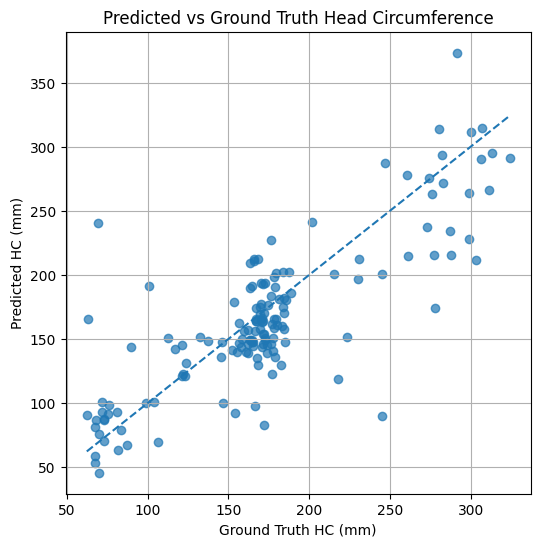

In [33]:
import matplotlib.pyplot as plt

y_true, y_pred = collect_predictions(model, test_df)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    linestyle="--"
)

plt.xlabel("Ground Truth HC (mm)")
plt.ylabel("Predicted HC (mm)")
plt.title("Predicted vs Ground Truth Head Circumference")
plt.grid(True)
plt.show()


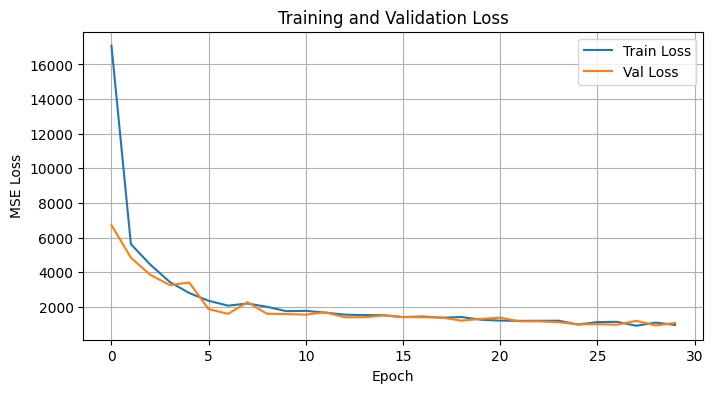

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


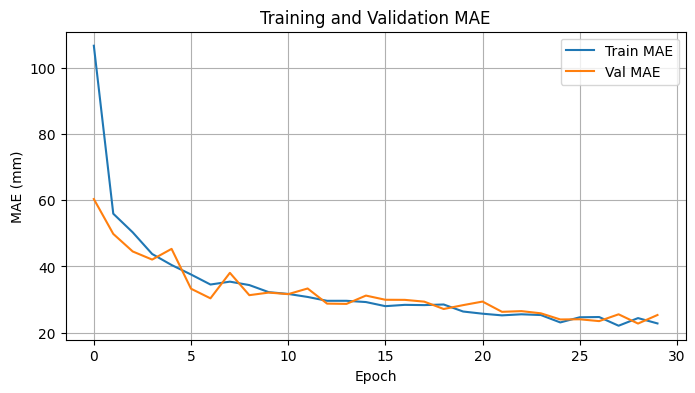

In [35]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")

plt.xlabel("Epoch")
plt.ylabel("MAE (mm)")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid(True)
plt.show()
